In [134]:
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from numpy import array
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np 
import pandas as pd 
import plotly.express as px
from datetime import datetime, timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [135]:
dataset_raw = pd.read_csv('C:/Users/Admin/Desktop/Final_Froject/data/HN_old.csv')
dataset_raw

,date,pm25,o3,no2,so2,co,aqi
0,2021/10/1,94,7,7,5,,
1,2021/10/2,80,16,9,5,,
2,2021/10/3,117,,,,,
3,2021/9/1,83,11,4,4,,
4,2021/9/2,69,10,5,5,,
...,...,...,...,...,...,...,...
2772,2015/12/15,,,,,18,
2773,2015/10/6,,,,,,117
2774,2015/10/7,,,,,,122
2775,2015/10/8,,,,,,144


In [136]:
def parse(x):
	return datetime.strptime(x,"%Y/%m/%d")
dataset = pd.read_csv('C:/Users/Admin/Desktop/Final_Froject/data/HN_old.csv',  parse_dates = ['date'], index_col=0, date_parser=parse)
dataset = dataset.replace(' ', 0,)
dataset.columns = ['pm25', 'o3', 'no2', 'so2', 'co', 'aqi']
dataset = dataset[:1968]
dataset.to_csv(r'C:/Users/Admin/Desktop/Final_Froject/data/HN_new.csv')

In [137]:
dataset_raw2 = pd.read_csv('C:/Users/Admin/Desktop/Final_Froject/data/HCM_old.csv')
dataset_raw2

,date,pm25
0,2021/10/1,67
1,2021/10/2,56
2,2021/10/3,55
3,2021/9/1,39
4,2021/9/2,39
...,...,...
1963,2016/3/27,106
1964,2016/3/28,117
1965,2016/3/29,136
1966,2016/3/30,92


In [138]:
def parse(x):
	return datetime.strptime(x,"%Y/%m/%d")
dataset1 = pd.read_csv('C:/Users/Admin/Desktop/Final_Froject/data/HCM_old.csv',  parse_dates = ['date'], index_col=0, date_parser=parse)
dataset1.columns = ['pm25']
dataset1['pm25'].fillna(0, inplace=True)
dataset1

,pm25
date,
2021-10-01,67
2021-10-02,56
2021-10-03,55
2021-09-01,39
2021-09-02,39
...,...
2016-03-27,106
2016-03-28,117
2016-03-29,136


In [139]:
dataset = pd.read_csv('TPHCM.csv')
train_dates = pd.to_datetime(dataset['date'])

In [140]:
# groupby_day = dataset.groupby(pd.PeriodIndex(data=dataset.date, freq='D'))
# results = groupby_day.sum()
# idx = pd.period_range(min(dataset.date), max(dataset.date))
# results.reindex(idx, fill_value=0)

In [141]:
# dataset = results
# train_dates = pd.to_datetime(dataset['date'])

In [142]:
cols = list(dataset)[1:2]

<AxesSubplot:>

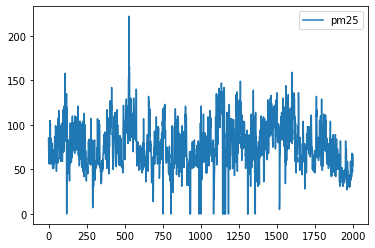

In [143]:
dataset_for_train_test = dataset[cols].astype(float)
dataset_for_train_test.plot.line()

In [144]:
n_train_day = 365 * 4
dataset_for_training = dataset_for_train_test.iloc[:n_train_day, :]
dataset_for_testing = dataset_for_train_test.iloc[n_train_day:, :]

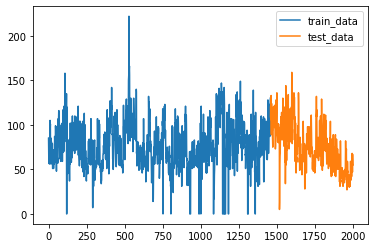

In [145]:
plt.plot(dataset_for_training,label = 'train_data')
plt.plot(dataset_for_testing,label = 'test_data')
plt.legend()
plt.show()

In [146]:
scaled = StandardScaler()
scaled = scaled.fit(dataset_for_training)
dataset_for_training_scaled = scaled.transform(dataset_for_training)
scaled = scaled.fit(dataset_for_testing)
dataset_for_testing_scaled = scaled.transform(dataset_for_testing)

In [147]:
trainX=[]
trainY=[]
testX=[]
testY=[]
n_future = 1
n_past = 14

In [148]:
for i in range(n_past, len(dataset_for_training_scaled) - n_future +1):
    trainX.append(dataset_for_training_scaled[i - n_past:i, 0:dataset_for_training.shape[1]])
    trainY.append(dataset_for_training_scaled[i + n_future - 1:i + n_future, 0])
    
for i in range(n_past, len(dataset_for_testing_scaled) - n_future +1):
    testX.append(dataset_for_testing_scaled[i - n_past:i, 0:dataset_for_testing.shape[1]])
    testY.append(dataset_for_testing_scaled[i + n_future - 1:i + n_future, 0])

In [149]:
trainX, trainY = np.array(trainX), np.array(trainY)
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
testX, testY = np.array(testX), np.array(testY)
print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (1446, 14, 1).
trainY shape == (1446, 1).
testX shape == (529, 14, 1).
testY shape == (529, 1).


In [150]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 14, 64)            16896     
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
82/82 - 2s - loss: 0.6859 - val_loss: 0.6721
Epoch 2/30
82/82 - 0s - loss: 0.6283 - val_loss: 0.6365
Epoch 3/30
82/82 - 0s - loss: 0.5594 - val_loss: 0.6193
Epoch 4/30
82/82 - 0s - loss: 0.5396 - val_loss: 0.6116
Epoch 5/30
82/82 - 0s - loss: 0.5468 - val_loss: 0.5960
Epoch 6/30
82/82 - 0s - loss: 0.5082 - val_loss: 0.6017
Epoch 7/30
82/82 - 0s - loss: 0.5090 - val_loss: 0.5983
Epoch 8/30
82/82 - 0s - loss: 0.5038 - val_loss: 0.5911
Epoch 9/30
82/82 - 0s - loss: 0.5005 - val_loss: 0.5843
Epoch 10/30
82/82 - 0s - loss: 0.4995 - val_loss: 0.5762
Epoch 11/30
82/82 - 0s - loss: 0.5014 - val_loss: 0.5791
Epoch 12/30
82/82 - 0s - loss: 0.5035 - val_loss: 0.5890
Epoch 13/30
82/82 - 0s - loss: 0.4989 - val_loss: 0.5742
Epoch 14/30
82/82 - 0s - loss: 0.4946 - val_loss: 0.5717
Epoch 15/30
82/82 - 0s - loss: 0.4953 - val_loss: 0.5694
Epoch 16/30
82/82 - 0s - loss: 0.4952 - val_loss: 0.5743
Epoch 17/30
82/82 - 0s - loss: 0.4877 - val_loss: 0.5768
Epoch 18/30
82/82 - 0s - loss: 0.4929 - 

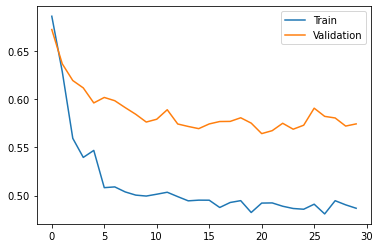

In [151]:
history = model.fit(trainX, trainY, epochs=30, batch_size=16, validation_split=0.1, verbose=2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()

In [152]:
n_future=30 
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()

forecast = model.predict(trainX[-n_future:]) #forecast 
# forecast = model.predict(testX)
# [-n_future:]

In [153]:
 trainY_inv = scaled.inverse_transform([trainY[-n_future:]])
# trainY_inv = scaled.inverse_transform([testY])
forecast_inv = scaled.inverse_transform([forecast])


In [154]:
nsamples, nx, ny = forecast_inv.shape
forecast_inv2 = forecast_inv.reshape((nsamples,nx*ny))
forecast_inv2[:-2]

array([], shape=(0, 30), dtype=float32)

In [155]:
nsamples, nx, ny = trainY_inv.shape
trainY_inv2 = trainY_inv.reshape((nsamples,nx*ny))
trainY_inv2[:-2]

array([], shape=(0, 30), dtype=float64)

In [156]:
a=math.sqrt(mean_squared_error(trainY_inv2,forecast_inv2))
print('Test Score: %.2f RMSE' % (a))

Test Score: 17.55 RMSE


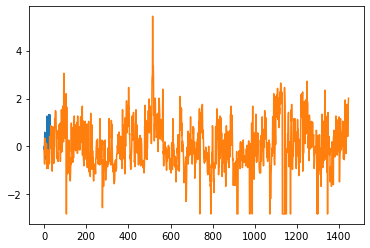

In [157]:
plt.plot(forecast)
plt.plot(trainY)
plt.show()

In [158]:
forecast_copies = np.repeat(forecast, dataset_for_training.shape[1], axis=-1)
y_pred_future = scaled.inverse_transform(forecast_copies)[:,0]

In [161]:
forecast_copies

array([[-0.01922562],
       [-0.14575341],
       [ 0.18018454],
       [ 0.591552  ],
       [ 0.24853982],
       [-0.01950831],
       [-0.49229175],
       [-0.07594088],
       [ 0.2841842 ],
       [-0.42934343],
       [-0.5490061 ],
       [-0.35295552],
       [ 0.07646026],
       [ 0.6631105 ],
       [ 1.2684932 ],
       [ 1.1468431 ],
       [ 0.23172812],
       [ 0.66032636],
       [-0.19158018],
       [-0.03610157],
       [ 0.46147534],
       [ 0.84916306],
       [ 1.0707144 ],
       [ 1.3336926 ],
       [ 1.1580336 ],
       [ 1.3012515 ],
       [ 0.42231154],
       [ 0.7523631 ],
       [ 0.87348056],
       [ 1.3035434 ]], dtype=float32)

<ipython-input-159-1ae7f63a31e9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['date']=pd.to_datetime(original['date'])
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

<AxesSubplot:xlabel='date', ylabel='pm25'>

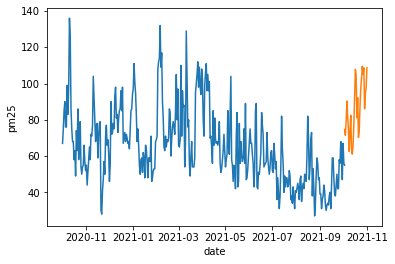

In [159]:
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'pm25':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])


original = dataset[['date', 'pm25']]
original['date']=pd.to_datetime(original['date'])
original = original.loc[original['date'] >= '2020-10-1']

sns.lineplot(original['date'], original['pm25'])
sns.lineplot(df_forecast['date'], df_forecast['pm25'])

In [160]:
df_forecast

,date,pm25
0,2021-10-03,74.702812
1,2021-10-04,71.450081
2,2021-10-05,79.829163
3,2021-10-06,90.404427
4,2021-10-07,81.586411
5,2021-10-08,74.695541
6,2021-10-09,62.541420
7,2021-10-10,73.244797
8,2021-10-11,82.502747
9,2021-10-12,64.159668
